In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a dataframe
df = pd.read_csv("south_downs_way.csv")

# Display the dataframe
df

,Unnamed: 0,latitude,longitude,time,elevation_change,elevation,speed,day,distance,gradient
0,0,51.061216,-1.309166,1.714728e+09,0.000000,38.000000,1.821046,1,0.000000,-0.022800
1,1,51.061194,-1.309031,1.714728e+09,0.000000,38.000000,2.111646,1,9.785721,-0.026704
2,2,51.061212,-1.309028,1.714728e+09,-0.200001,37.799999,2.631965,1,2.026501,-0.030729
3,3,51.061201,-1.308969,1.714728e+09,-0.200001,37.599998,3.265195,1,4.281546,-0.031380
4,4,51.061190,-1.308957,1.714728e+09,0.000000,37.599998,3.852399,1,1.521301,-0.028568
...,...,...,...,...,...,...,...,...,...,...
14146,14146,50.896832,-0.542086,1.714998e+09,0.000000,4.000000,1.071414,4,1.456105,0.012295
14147,14147,50.896832,-0.542083,1.714998e+09,0.000000,4.000000,1.024777,4,0.188932,0.008481
14148,14148,50.896832,-0.542081,1.714998e+09,0.000000,4.000000,0.997165,4,0.165377,0.004550
14149,14149,50.896836,-0.542076,1.714998e+09,0.000000,4.000000,1.013259,4,0.567449,0.001926


[]

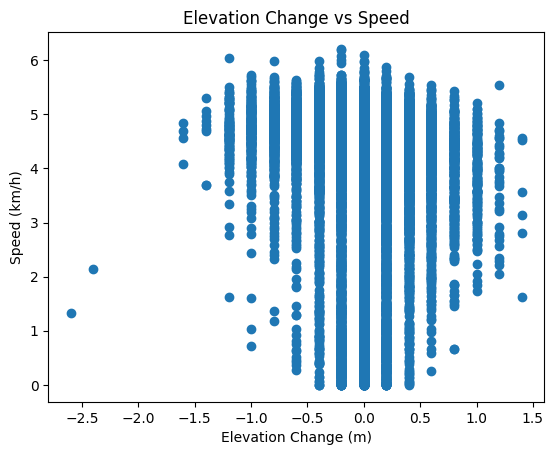

In [41]:
fig, ax = plt.subplots()
ax.scatter(df["elevation_change"], df["speed"])
ax.set_xlabel("Elevation Change (m)")
ax.set_ylabel("Speed (km/h)")

ax.set_title("Elevation Change vs Speed")
plt.plot()

### What does this mean?

I think there is a lot going on in this graph. First of all, we can see elevations are quantised at exactly .2m intervals, but that should not affect the data too much. Next, I notice the 0 speed values. There is a significant block of 0 speed values between -.5 and +.5 elevation. I believe this is because when we slow down, we change less elevation. We can see that the bottom end of the speeds tail off as the elevation increases, because when we walk faster, we gain more elevation. How do I solve this problem? 

I think dimensionality reduction may solve our problem. The problem is there is a correlation between speed and elevation change, not just vise versa. As one walks faster, they traverse more elevation. Dimensionality reduction I believe would remove this, so let's try it. 

Alternatively, a simpler or more naive approach would be to remove all points at less than 1kph, because that is not a full walking pace. 

The third and final solution is to measure correlation using gradient instead of absolute elevation change. A percentage based metric would account for low end values, as if one is travelling slower, their gradient will not be affected. 

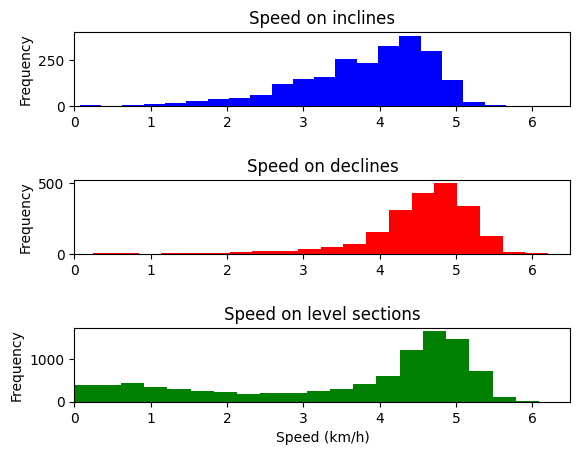

In [42]:
def separate_speeds(df):
  turning_point = .06
  incline_df = df[df["gradient"] > turning_point]
  decline_df = df[df["gradient"] < -turning_point]
  level_df = df[(df["gradient"] > -turning_point) & (df["gradient"] < turning_point)]
  return incline_df, decline_df, level_df

def separate_speeds_and_plot(df): 
  incline_df, decline_df, level_df = separate_speeds(df)

  fig, axs = plt.subplots(3)
  bins = 20

  axs[0].hist(incline_df["speed"], bins=bins, color="b")
  # axs[0].set_xlabel("Speed (km/h)")
  axs[0].set_ylabel("Frequency")
  axs[0].set_title("Speed on inclines")

  axs[1].hist(decline_df["speed"], bins=bins, color="r")
  # axs[1].set_xlabel("Speed (km/h)")
  axs[1].set_ylabel("Frequency")
  axs[1].set_title("Speed on declines")

  axs[2].hist(level_df["speed"], bins=bins, color="g")
  axs[2].set_xlabel("Speed (km/h)")
  axs[2].set_ylabel("Frequency")
  axs[2].set_title("Speed on level sections")
  
  for ax in axs:
    ax.set_xlim(0, 6.5)
    ax.set_xticks(range(0,7))
    ax.set_xticklabels(range(0,7))
  

  plt.tick_params(axis='x', labelbottom=True)

  plt.subplots_adjust(hspace=1)
  plt.plot()
separate_speeds_and_plot(df)

## Conclusions

The information seems to be distilled here. Here is what jumps out at me:

* The level dataset has a heavy tail. This is because of *faffing*, which is anything from breaking to arguing about directions
* The modal value for speed on inclines is 4.4km/h, while the mode for the level is 4.6 and decline data is around 4.8
* There is much more data for level than decines than inclines


In [43]:
incline_df, decline_df, level_df = separate_speeds(df)
print(incline_df["speed"].describe(), decline_df["speed"].describe(), level_df["speed"].describe())

count    2287.000000
mean        3.810564
std         0.867932
min         0.071849
25%         3.328584
50%         3.998367
75%         4.457148
max         5.654274
Name: speed, dtype: float64 count    2111.000000
mean        4.544256
std         0.716602
min         0.245106
25%         4.276637
50%         4.677256
75%         4.982319
max         6.206429
Name: speed, dtype: float64 count    9753.000000
mean        3.583114
std         1.662098
min         0.000000
25%         2.240829
50%         4.356826
75%         4.850753
max         6.089173
Name: speed, dtype: float64


## Correlation Testing 
I want to see if the level and decline sections are correlated

In [44]:
from scipy.stats import pearsonr
import random
## The arrays must be the same length, and level is longer

x = level_df["speed"].values
random.shuffle(x)
x = x[:len(decline_df["speed"])]

y = decline_df["speed"].values

pearson_corr, pearson_p_value = pearsonr(x, y)
print(f"Pearson correlation coefficient: {pearson_corr} and p-value: {pearson_p_value}")

Pearson correlation coefficient: -0.05817392140996036 and p-value: 0.0075060240538978255


## Eliminating faffing

I do not like faffing, and I think it is irrepresentative of the premise of the dataset, which is to analyse walking speed at walking pace. I will try two methods: Removing all speeds below 2 or 3, and PCA. First lets try the former

In [45]:
for thresh in (2, 3):
  incline_thresholded = incline_df[incline_df["speed"] > thresh]

  def shuffle_and_truncate(x, y): 
    if len(x) > len(y):
      random.shuffle(x)
      x = x[:len(y)]
    else:
      random.shuffle(y)
      y = y[:len(x)]
    return x, y

  threshold_speed = incline_thresholded["speed"].values
  y = decline_df["speed"].values

  x2, y2 = shuffle_and_truncate(threshold_speed, y)

  pearson_corr2, pearson_p_value2 = pearsonr(x2, y2)
  print(f"Pearson correlation coefficient for {thresh}: {pearson_corr2} and p-value: {pearson_p_value2}")

Pearson correlation coefficient for 2: -0.022195399599792196 and p-value: 0.3080591679836514
Pearson correlation coefficient for 3: 0.012218101325115648 and p-value: 0.5951402968794838


The p value randomises each time 

## Gradient

I believe that using gradient in my analysis will yield better result

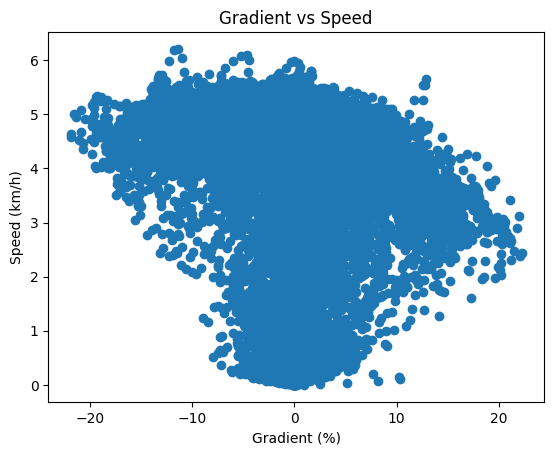

In [46]:
def plot_speed_vs_gradient(df, c=None):
  fig, ax = plt.subplots()
  ax.scatter((df["gradient"]) * 100, df["speed"], color=c)
  ax.set_xlabel("Gradient (%)")
  ax.set_ylabel("Speed (km/h)")

  ax.set_title("Gradient vs Speed")
  plt.plot()

plot_speed_vs_gradient(df)

[]

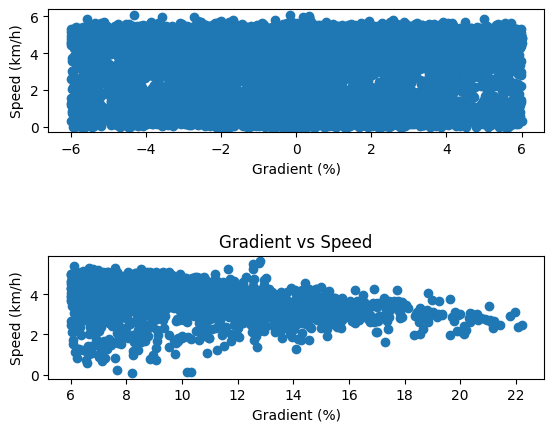

In [47]:
fig, axs = plt.subplots(2)
for (ax, df) in zip(axs, [level_df, incline_df]):
  ax.scatter((df["gradient"]) * 100, df["speed"])
  ax.set_xlabel("Gradient (%)")
  ax.set_ylabel("Speed (km/h)")
  ax.plot()

plt.title("Gradient vs Speed")
plt.subplots_adjust(hspace=1)
plt.plot()


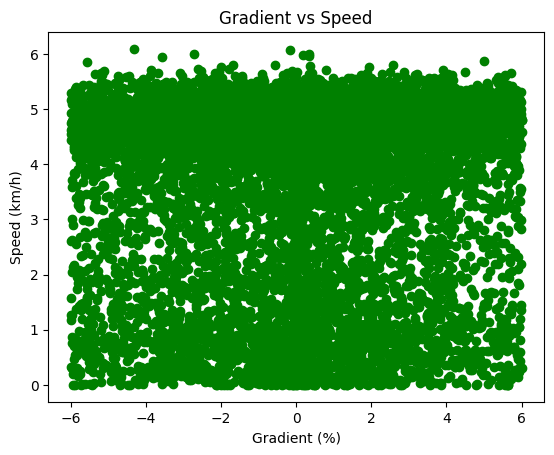

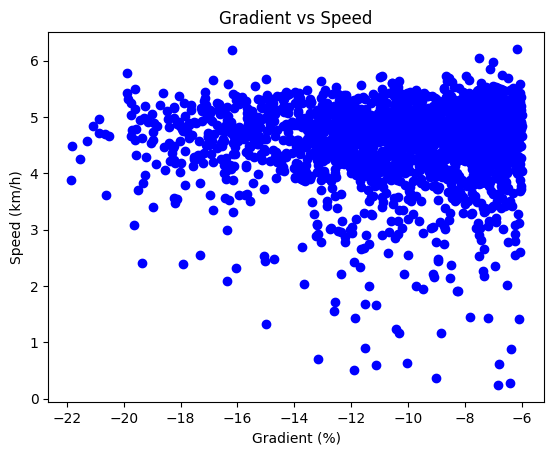

In [48]:
plot_speed_vs_gradient(level_df, c="g")
plot_speed_vs_gradient(decline_df, c="b")

The difference is visually apparent, so I want to use exclusively speed instead 

## K means
I need average values for times of each day, so why not use k means

/home/beanboy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


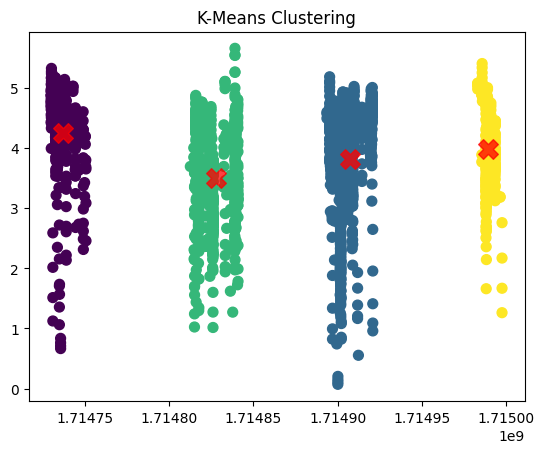

[1714736891.8455498, 1714827976.70319, 1714907213.640625, 1714989054.46875]


In [49]:
from sklearn.cluster import KMeans

X = df[["time", "speed"]].values

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
# Plot the clustered data
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-Means Clustering')
plt.show()

times = [c[0] for c in centers]
times.sort()
print(times)

In [50]:
X

array([[1.71473010e+09, 4.43302565e+00],
       [1.71473011e+09, 4.55106888e+00],
       [1.71473012e+09, 4.63840300e+00],
       ...,
       [1.71499753e+09, 1.66801574e+00],
       [1.71499754e+09, 2.16932205e+00],
       [1.71499754e+09, 2.75748732e+00]])